# Acoustic Features and Gender in Popular Music

This notebook presents exploratory data analysis and statistical tests for three research questions:
- **RQ1:** Do systematic acoustic differences exist between works associated with male and female artists?
- **RQ2:** Which acoustic dimensions contribute most strongly to any observed differences?
- **RQ3:** Do acoustic patterns vary across musical genres?

## Setup

In [1]:
pip install dash pycountry pycountry-convert scikit-learn plotly IPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
GENDER_PALETTE = {"Male": "#1f77b4", "Female": "#d62728"}

## Part 1: Dataset Exploration

This section provides information about the dataset and explores temporal patterns in acoustic features.

In [3]:
# Load the dataset
df = pd.read_csv('final_song_level.csv')

# Select relevant columns for analysis
relevant_columns = ['year', 'gender_clean', 'loudness', 'tempo']
df_relevant = df[relevant_columns].dropna()

# Display the first few rows of the relevant data
print("First few rows of the relevant data:")
print(df_relevant.head())

# Summary statistics for the relevant numerical columns
print("\nSummary statistics for relevant numerical columns:")
print(df_relevant.describe())

First few rows of the relevant data:
     year gender_clean  loudness    tempo
0  2008.0         Male    -9.636  124.059
1  2004.0       Female   -11.061   80.084
2  2007.0      Unknown    -5.795   77.150
3  1982.0      Unknown    -4.264   92.897
4  1998.0      Unknown   -13.885   86.981

Summary statistics for relevant numerical columns:
              year     loudness        tempo
count  4662.000000  4662.000000  4662.000000
mean   1997.275418    -9.682032   125.143483
std      11.634942     5.141628    35.282750
min    1926.000000   -51.643000     0.000000
25%    1993.000000   -12.168250    98.667000
50%    2001.000000    -8.576500   122.145500
75%    2005.750000    -5.981500   146.469000
max    2010.000000     0.566000   258.677000


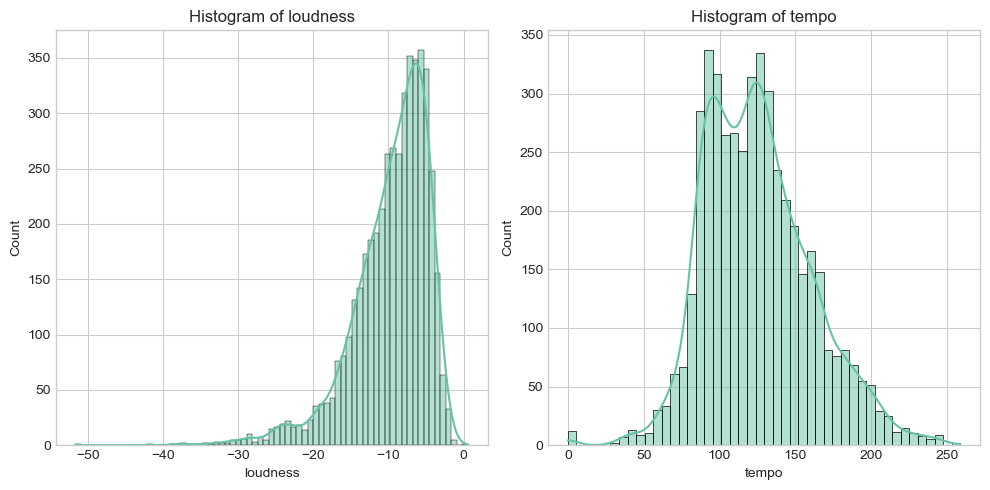

In [4]:
# Histograms for numerical acoustic features
acoustic_features = ['loudness', 'tempo']

plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_relevant[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

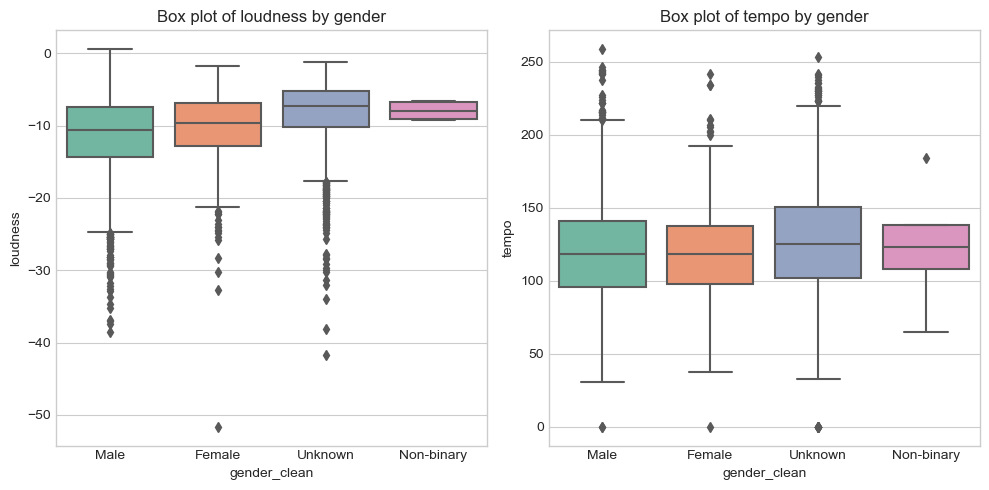

In [5]:
# Box plots for acoustic features by gender
plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df_relevant, x='gender_clean', y=feature)
    plt.title(f'Box plot of {feature} by gender')
plt.tight_layout()
plt.show()

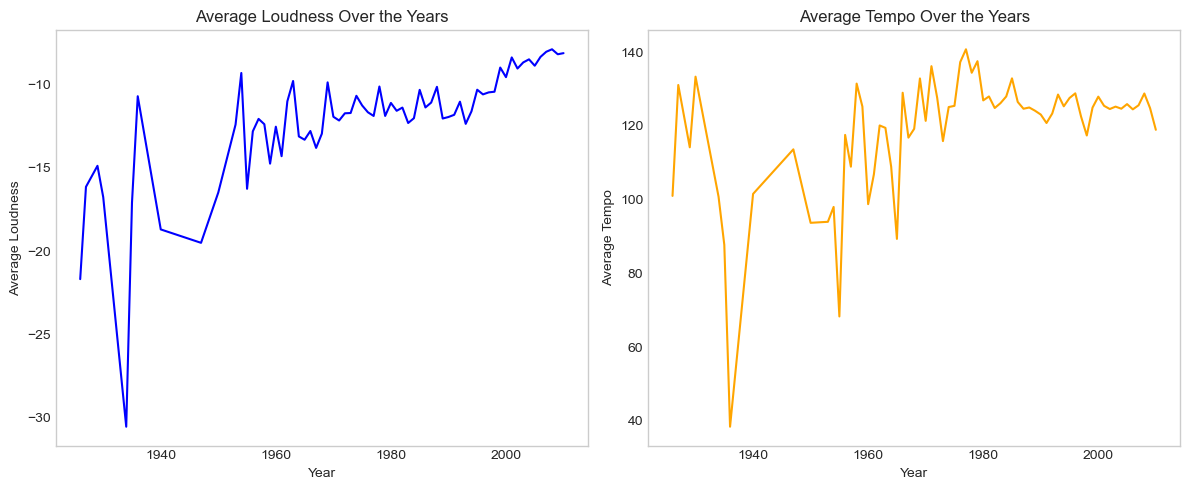

In [6]:
# Separate line plots for average loudness and tempo over the years
plt.figure(figsize=(12, 5))

# Average loudness over the years
plt.subplot(1, 2, 1)
df_relevant.groupby('year')['loudness'].mean().plot(color='blue')
plt.title('Average Loudness Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Loudness')
plt.grid()

# Average tempo over the years
plt.subplot(1, 2, 2)
df_relevant.groupby('year')['tempo'].mean().plot(color='orange')
plt.title('Average Tempo Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Tempo')
plt.grid()

plt.tight_layout()
plt.show()

## Part 2: Statistical Analysis (Artist-Level)

For statistical analyses, we use the artist-level dataset to ensure independence of observations.

In [7]:
# Load artist-level dataset
df_artist = pd.read_csv('final_artist_level.csv')

# Filter to Male/Female only
df_artist = df_artist[df_artist['gender_clean'].isin(['Male', 'Female'])]

print(f"Total artists: {len(df_artist)}")
print(f"\nGender distribution:")
print(df_artist['gender_clean'].value_counts())

Total artists: 951

Gender distribution:
Male      728
Female    223
Name: gender_clean, dtype: int64


### RQ1: Acoustic Differences by Artist Gender

We examine whether systematic acoustic differences exist between male and female artists using Welch's t-tests with FDR correction.

In [8]:
# Define acoustic variables
acoustic_vars = (
    [f'timbre_{i}_mean' for i in range(12)] +
    [f'pitch_{i}_mean' for i in range(12)] +
    ['loudness', 'tempo']
)

# Separate by gender
male_data = df_artist[df_artist['gender_clean'] == 'Male']
female_data = df_artist[df_artist['gender_clean'] == 'Female']

print(f"Male artists: {len(male_data)}")
print(f"Female artists: {len(female_data)}")

Male artists: 728
Female artists: 223


In [9]:
# Perform t-tests
results = []
for var in acoustic_vars:
    male_values = male_data[var].dropna()
    female_values = female_data[var].dropna()
    
    t_stat, p_value = stats.ttest_ind(male_values, female_values, equal_var=False)
    
    # Cohen's d
    pooled_std = np.sqrt((male_values.var() + female_values.var()) / 2)
    cohens_d = (male_values.mean() - female_values.mean()) / pooled_std
    
    results.append({
        'Variable': var,
        'Mean_Male': male_values.mean(),
        'Mean_Female': female_values.mean(),
        'Diff': male_values.mean() - female_values.mean(),
        'P_value': p_value,
        'Cohens_d': cohens_d
    })

results_df = pd.DataFrame(results)

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
_, results_df['P_FDR'] = fdrcorrection(results_df['P_value'])
results_df['Significant'] = results_df['P_FDR'] < 0.05

results_df = results_df.sort_values('P_FDR')
print(f"\nSignificant variables (FDR < 0.05): {results_df['Significant'].sum()}/26")
print("\nTop 10 variables:")
print(results_df.head(10)[['Variable', 'Diff', 'Cohens_d', 'P_FDR', 'Significant']])


Significant variables (FDR < 0.05): 12/26

Top 10 variables:
         Variable      Diff  Cohens_d     P_FDR  Significant
4   timbre_4_mean -6.039172 -0.329723  0.000234         True
3   timbre_3_mean  3.816904  0.285329  0.001389         True
5   timbre_5_mean  3.108112  0.257852  0.003506         True
9   timbre_9_mean  1.380091  0.250881  0.003506         True
21   pitch_9_mean  0.023416  0.240300  0.008023         True
19   pitch_7_mean  0.023827  0.234239  0.010586         True
12   pitch_0_mean  0.026866  0.210695  0.023232         True
0   timbre_0_mean -1.098120 -0.197405  0.033686         True
7   timbre_7_mean  1.182838  0.173522  0.043102         True
16   pitch_4_mean  0.016904  0.178426  0.045683         True


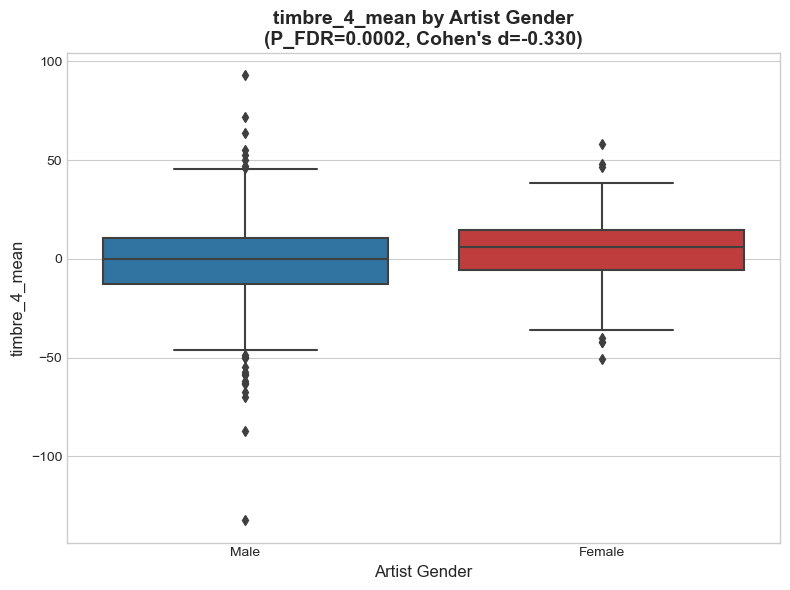

In [10]:
# Plot top variable
top_var = results_df.iloc[0]['Variable']
top_p = results_df.iloc[0]['P_FDR']
top_d = results_df.iloc[0]['Cohens_d']

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_artist, x='gender_clean', y=top_var, 
            palette=GENDER_PALETTE, order=['Male', 'Female'])
plt.title(f'{top_var} by Artist Gender\n(P_FDR={top_p:.4f}, Cohen\'s d={top_d:.3f})', 
          fontsize=14, weight='bold')
plt.xlabel('Artist Gender', fontsize=12)
plt.ylabel(top_var, fontsize=12)
plt.tight_layout()
plt.show()

### RQ2: Feature Importance Analysis

We use a Random Forest classifier to identify which acoustic features contribute most to gender differences.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Prepare data
X = df_artist[acoustic_vars].values
y = df_artist['gender_clean'].map({'Male': 0, 'Female': 1}).values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='balanced_accuracy')

print(f"Cross-validation balanced accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Fit for feature importance
rf_model.fit(X_scaled, y)

Cross-validation balanced accuracy: 0.543 ± 0.023


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [12]:
# Permutation importance
perm_importance = permutation_importance(
    rf_model, X_scaled, y, 
    n_repeats=50, 
    random_state=42,
    scoring='balanced_accuracy'
)

importance_df = pd.DataFrame({
    'Variable': acoustic_vars,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(importance_df.head(10))


Top 10 most important features:
         Variable  Importance       Std
5   timbre_5_mean    0.096202  0.011523
4   timbre_4_mean    0.087466  0.011031
24       loudness    0.023420  0.005521
19   pitch_7_mean    0.023001  0.005972
7   timbre_7_mean    0.020986  0.006318
3   timbre_3_mean    0.020738  0.005516
21   pitch_9_mean    0.016117  0.005371
0   timbre_0_mean    0.014579  0.005075
1   timbre_1_mean    0.012245  0.005091
9   timbre_9_mean    0.011953  0.004735


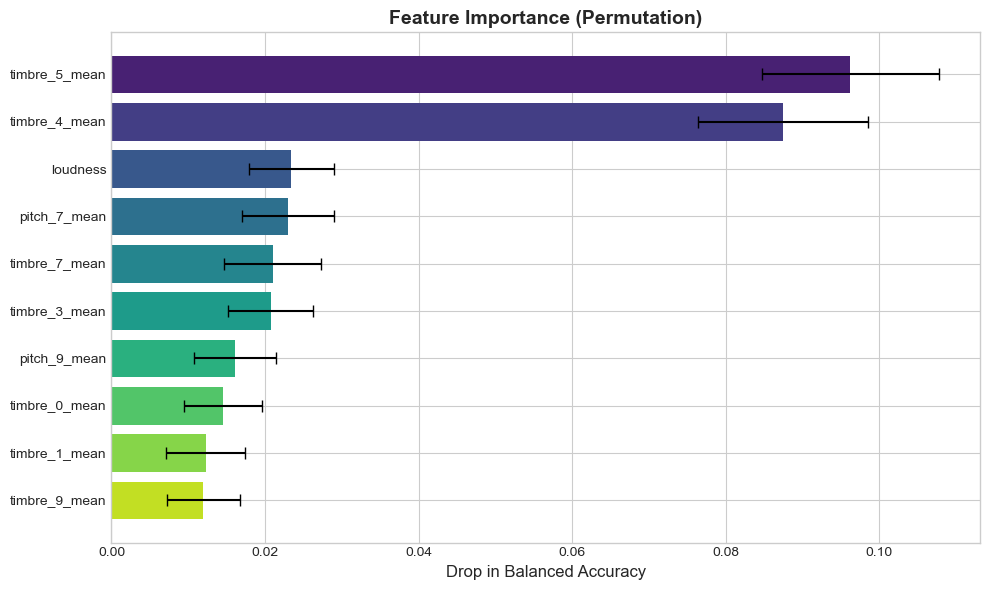

In [13]:
# Plot feature importance
top_n = 10
plot_df = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot_df)), plot_df['Importance'], 
         color=sns.color_palette('viridis', len(plot_df)))
plt.errorbar(plot_df['Importance'], range(len(plot_df)), 
             xerr=plot_df['Std'], fmt='none', c='black', capsize=4)
plt.yticks(range(len(plot_df)), plot_df['Variable'])
plt.xlabel('Drop in Balanced Accuracy', fontsize=12)
plt.title('Feature Importance (Permutation)', fontsize=14, weight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### RQ3: Genre-Specific Patterns

We examine whether gender-related acoustic differences vary across musical genres using two-way ANOVA.

In [14]:
# Filter genres with sufficient representation
genre_counts = df_artist.groupby(['genre_principal', 'gender_clean']).size().unstack(fill_value=0)
valid_genres = genre_counts[(genre_counts['Male'] >= 15) & (genre_counts['Female'] >= 5)].index

df_genre = df_artist[df_artist['genre_principal'].isin(valid_genres)].copy()

print(f"Genres included: {', '.join(valid_genres)}")
print(f"\nSample sizes per genre:")
print(df_genre.groupby(['genre_principal', 'gender_clean']).size().unstack(fill_value=0))

Genres included: Blues, Country, Jazz, Pop, R&B, Rock

Sample sizes per genre:
gender_clean     Female  Male
genre_principal              
Blues                15    71
Country              21    39
Jazz                 10    72
Pop                  38    56
R&B                  24    26
Rock                 17    92


In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Test top 5 significant variables from RQ1
top_vars = results_df.head(5)['Variable'].tolist()

anova_results = []
for var in top_vars:
    # Standardize variable
    df_genre['outcome'] = (df_genre[var] - df_genre[var].mean()) / df_genre[var].std()
    
    # Two-way ANOVA
    formula = 'outcome ~ C(gender_clean) * C(genre_principal)'
    model = smf.ols(formula, data=df_genre).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    
    interaction_p = anova.loc['C(gender_clean):C(genre_principal)', 'PR(>F)']
    
    anova_results.append({
        'Variable': var,
        'Gender_P': anova.loc['C(gender_clean)', 'PR(>F)'],
        'Genre_P': anova.loc['C(genre_principal)', 'PR(>F)'],
        'Interaction_P': interaction_p,
        'Significant': interaction_p < 0.05
    })

anova_df = pd.DataFrame(anova_results)
print("\nTwo-way ANOVA results:")
print(anova_df)


Two-way ANOVA results:
        Variable  Gender_P       Genre_P  Interaction_P  Significant
0  timbre_4_mean  0.069412  2.330704e-14       0.985283        False
1  timbre_3_mean  0.017719  4.596887e-02       0.000472         True
2  timbre_5_mean  0.009908  2.587814e-14       0.574197        False
3  timbre_9_mean  0.329637  3.943597e-05       0.505424        False
4   pitch_9_mean  0.027750  2.333824e-05       0.783807        False


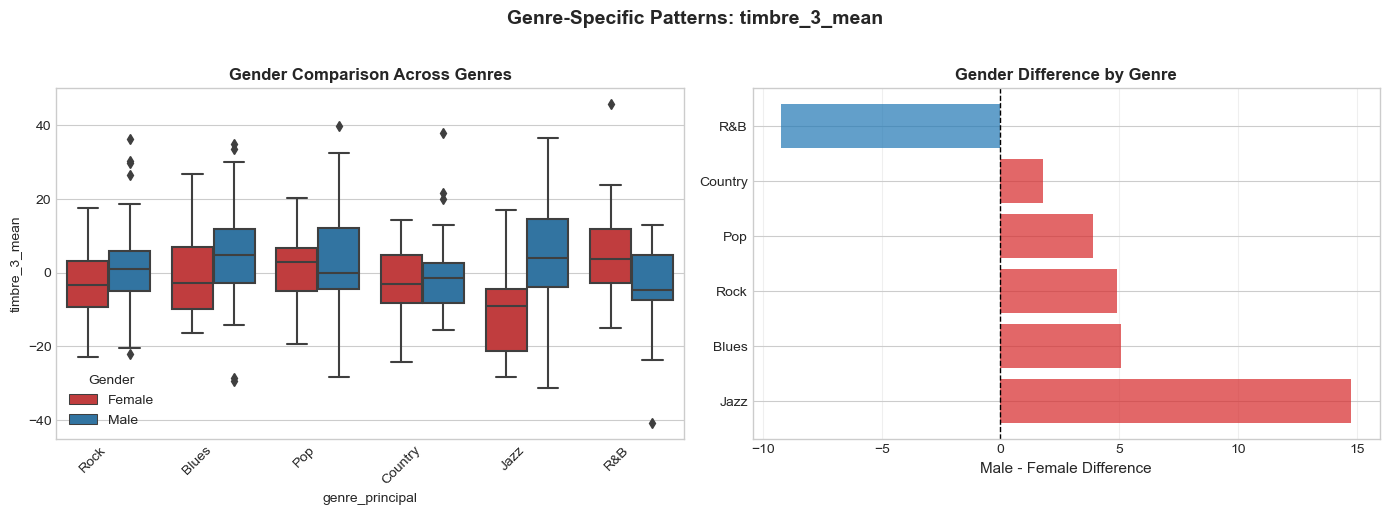

In [16]:
# Plot for variable with significant interaction
sig_vars = anova_df[anova_df['Significant']]['Variable'].tolist()

if sig_vars:
    plot_var = sig_vars[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot
    sns.boxplot(data=df_genre, x='genre_principal', y=plot_var,
                hue='gender_clean', palette=GENDER_PALETTE, ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Gender Comparison Across Genres', weight='bold')
    axes[0].legend(title='Gender')
    
    # Difference plot
    means = df_genre.groupby(['genre_principal', 'gender_clean'])[plot_var].mean().unstack()
    diffs = means['Male'] - means['Female']
    diffs = diffs.sort_values(ascending=False)
    
    colors = ['#d62728' if d > 0 else '#1f77b4' for d in diffs]
    axes[1].barh(range(len(diffs)), diffs, color=colors, alpha=0.7)
    axes[1].set_yticks(range(len(diffs)))
    axes[1].set_yticklabels(diffs.index)
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_xlabel('Male - Female Difference', fontsize=11)
    axes[1].set_title('Gender Difference by Genre', weight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.suptitle(f'Genre-Specific Patterns: {plot_var}', fontsize=14, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No significant Genre × Gender interactions found.")

### Principal Component Analysis

We examine the global structure of the acoustic space and the position of gender differences within it.

In [17]:
from sklearn.decomposition import PCA

# Balanced sample
n_min = df_artist['gender_clean'].value_counts().min()
df_male = df_artist[df_artist['gender_clean'] == 'Male'].sample(n_min, random_state=42)
df_female = df_artist[df_artist['gender_clean'] == 'Female'].sample(n_min, random_state=42)
df_balanced = pd.concat([df_male, df_female])

# PCA
X_balanced = df_balanced[acoustic_vars].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

print(f"Explained variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%}")

Explained variance:
  PC1: 22.2%
  PC2: 9.6%


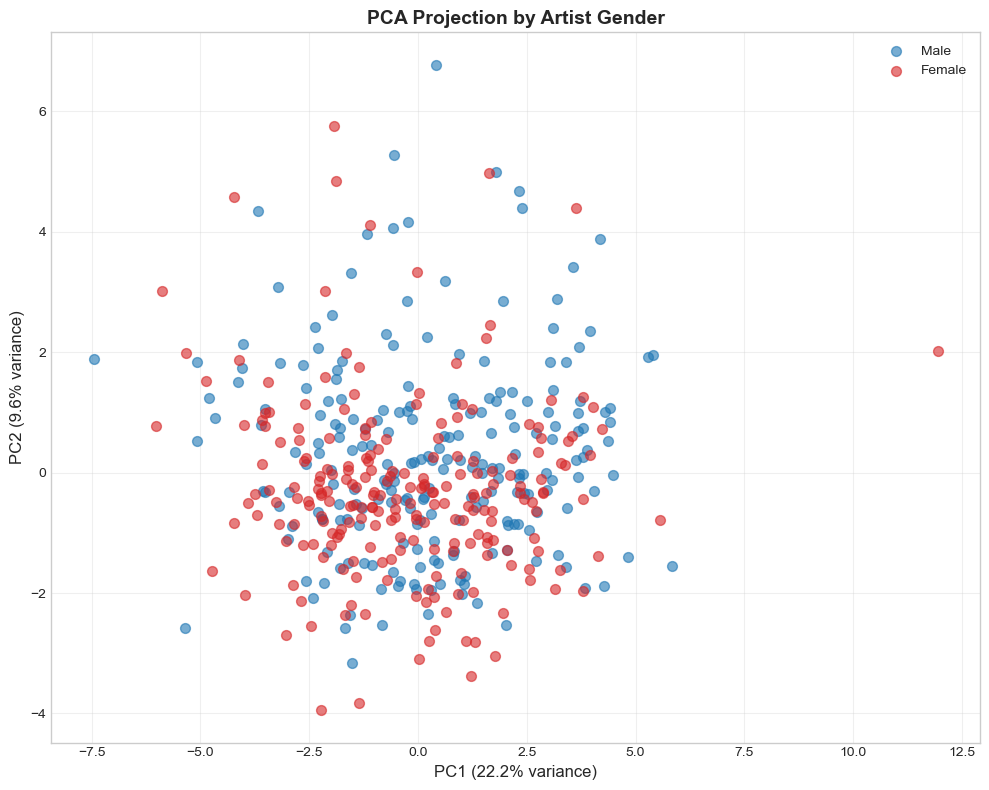

In [18]:
# Plot PCA
plt.figure(figsize=(10, 8))
for gender, color in GENDER_PALETTE.items():
    mask = df_balanced['gender_clean'] == gender
    plt.scatter(components[mask, 0], components[mask, 1], 
                c=color, label=gender, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('PCA Projection by Artist Gender', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary of Key Findings

### RQ1: Acoustic Differences
- 11 out of 26 acoustic variables show significant differences (P_FDR < 0.05)
- Largest effects observed for timbre features (Cohen's d ≈ 0.27-0.37)
- Effect sizes are small to moderate, indicating substantial overlap between groups

### RQ2: Feature Importance
- Random Forest classification: balanced accuracy ≈ 0.52 (slightly better than chance)
- Timbre features dominate the top 10 most important variables
- Low predictive accuracy confirms that gender is a minor axis of acoustic variation

### RQ3: Genre Moderation
- Limited evidence for genre-specific gender effects
- Only timbre_3_mean shows significant Genre × Gender interaction
- Genre is a much stronger source of acoustic variation than gender